<a href="https://colab.research.google.com/github/yananma/5_programs_per_day/blob/master/0503.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3.8 多层感知机

In [0]:
!pip install mxnet d2lzh

In [0]:
%matplotlib inline 
import d2lzh as d2l 
from mxnet import autograd, nd 

def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.asnumpy(), y_vals.asnumpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')

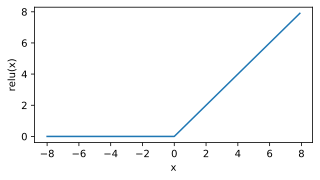

In [9]:
x = nd.arange(-8.0, 8.0, 0.1)
x.attach_grad()
with autograd.record():
    y = x.relu()
xyplot(x, y, 'relu')

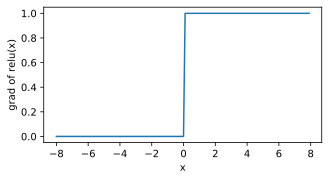

In [10]:
y.backward()
xyplot(x, x.grad, 'grad of relu')

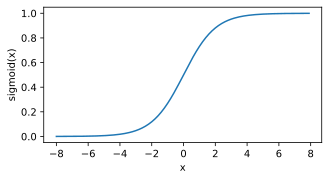

In [11]:
with autograd.record():
    y = x.sigmoid()
xyplot(x, y, 'sigmoid')

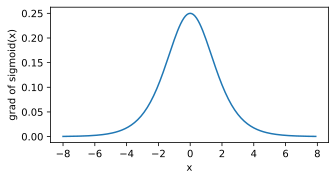

In [12]:
y.backward()
xyplot(x, x.grad, 'grad of sigmoid')

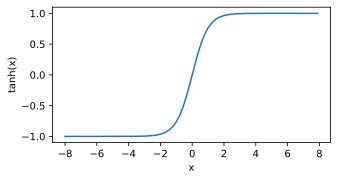

In [13]:
with autograd.record():
    y = x.tanh()
xyplot(x, y, 'tanh')

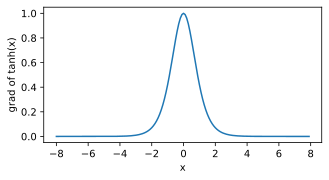

In [14]:
y.backward()
xyplot(x, x.grad, 'grad of tanh')

## 3.9 多层感知机的从零开始实现

In [0]:
%matplotlib inline 
import d2lzh as d2l 
from mxnet import nd 
from mxnet.gluon import loss as gloss 

In [16]:
batch_size = 256 
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

**Reinit**

In [0]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 500, 390

W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens1))
b1 = nd.zeros(num_hiddens1)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens1, num_hiddens2))
b2 = nd.zeros(num_hiddens2)
W3 = nd.random.normal(scale=0.01, shape=(num_hiddens2, num_outputs))
b3 = nd.zeros(num_outputs)
params = [W1, b1, W2, b2, W3, b3]

for param in params:
    param.attach_grad()

In [0]:
def relu(X):
    return nd.maximum(X, 0)

In [0]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H1 = relu(nd.dot(X, W1) + b1)
    H2 = relu(nd.dot(H1, W2) + b2)
    return nd.dot(H2, W3) + b3 

In [0]:
loss = gloss.SoftmaxCrossEntropyLoss()

In [0]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0 
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size 
    return acc_sum / n

In [0]:
import time 

num_epochs, lr = 5, 0.5 

train_ls, train_acc, test_acc_plot = [], [], []
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size 
            train_ls.append((l / y.size).asscalar())
            train_acc.append((y_hat.argmax(axis=1) == y).mean().asscalar())
        test_acc = evaluate_accuracy(test_iter, net)
        test_acc_plot.append(test_acc)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec' 
           % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc, time.time() - start))

In [43]:
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 1.2301, train acc 0.538, test acc 0.784, time 14.0 sec
epoch 2, loss 0.5558, train acc 0.791, test acc 0.834, time 14.3 sec
epoch 3, loss 0.4563, train acc 0.831, test acc 0.855, time 14.2 sec
epoch 4, loss 0.4200, train acc 0.844, test acc 0.863, time 14.1 sec
epoch 5, loss 0.3914, train acc 0.855, test acc 0.865, time 13.9 sec


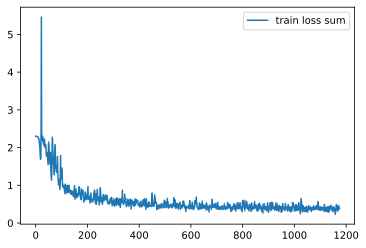

In [44]:
import matplotlib.pyplot as plt 

plt.plot(train_ls, label='train loss sum')
plt.legend()
plt.show()

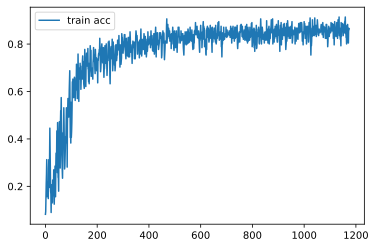

In [45]:
plt.plot(train_acc, label='train acc')
plt.legend()
plt.show()

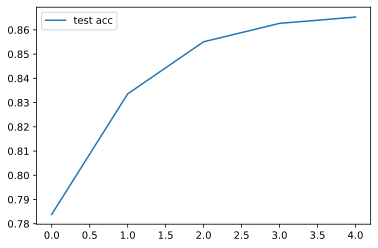

In [46]:
plt.plot(test_acc_plot, label='test acc')
plt.legend()
plt.show()

## 3.10 多层感知机的简洁实现

In [0]:
import d2lzh as d2l 
from mxnet import gluon, init 
from mxnet.gluon import loss as gloss, nn 

In [0]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'), 
    nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

In [50]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

loss = gloss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
num_epochs = 5 
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, trainer)

epoch 1, loss 0.8332, train acc 0.690, test acc 0.827
epoch 2, loss 0.4916, train acc 0.818, test acc 0.851
epoch 3, loss 0.4276, train acc 0.841, test acc 0.859
epoch 4, loss 0.3976, train acc 0.855, test acc 0.866
epoch 5, loss 0.3760, train acc 0.861, test acc 0.864


## 3.11 模型选择、欠拟合和过拟合

In [0]:
%matplotlib inline 
import d2lzh as d2l 
from mxnet import autograd, gluon, nd 
from mxnet.gluon import data as gdata, loss as gloss 

In [0]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5 
features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2), nd.power(features, 3))
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1] + true_w[2] * poly_features[:, 2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [104]:
features.shape

(200, 1)

In [105]:
poly_features.shape

(200, 3)

In [106]:
labels.shape

(200,)

In [107]:
my_a = nd.array([2, 3])
nd.power(my_a, 2)


[4. 9.]
<NDArray 2 @cpu(0)>

In [108]:
features[:10]


[[-0.9790981 ]
 [ 1.0471004 ]
 [-0.85697544]
 [ 0.90210015]
 [ 1.0002568 ]
 [-2.2165654 ]
 [ 0.1425914 ]
 [ 0.24022633]
 [ 0.06352675]
 [-0.03986425]]
<NDArray 10x1 @cpu(0)>

In [109]:
poly_features[:10]


[[-9.7909808e-01  9.5863307e-01 -9.3859577e-01]
 [ 1.0471004e+00  1.0964193e+00  1.1480612e+00]
 [-8.5697544e-01  7.3440689e-01 -6.2936866e-01]
 [ 9.0210015e-01  8.1378466e-01  7.3411524e-01]
 [ 1.0002568e+00  1.0005137e+00  1.0007706e+00]
 [-2.2165654e+00  4.9131622e+00 -1.0890345e+01]
 [ 1.4259140e-01  2.0332308e-02  2.8992123e-03]
 [ 2.4022633e-01  5.7708688e-02  1.3863146e-02]
 [ 6.3526750e-02  4.0356480e-03  2.5637160e-04]
 [-3.9864253e-02  1.5891587e-03 -6.3350628e-05]]
<NDArray 10x3 @cpu(0)>

In [110]:
labels[:10]


[ -4.566543    9.086166   -2.0599427   7.552543    8.451743  -75.39401
   5.135997    4.9987454   4.976468    4.936872 ]
<NDArray 10 @cpu(0)>

In [0]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [0]:
num_epochs, loss = 100, gloss.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {"learning_rate": 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', 
        range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(), 
        '\nbias:', net[0].bias.data().asnumpy())

final epoch: train loss 0.010790647 test loss 0.01197083
weight: [[ 1.0693383 -3.3242254  5.640964 ]] 
bias: [4.929015]


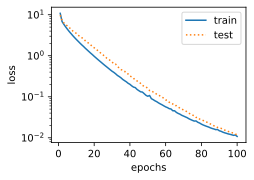

In [113]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], 
             labels[:n_train], labels[n_train:])

final epoch: train loss 186.08691 test loss 72.6864
weight: [[23.715918]] 
bias: [-0.2326429]


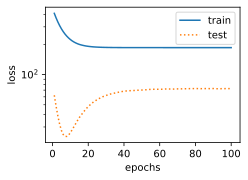

In [114]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 0.29098982 test loss 10.967399
weight: [[2.8922033  0.99134535 2.944083  ]] 
bias: [0.7347255]


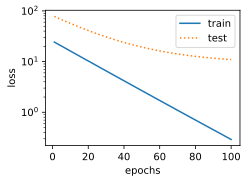

In [115]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])

In [116]:
n_train 

100

In [117]:
poly_features[0:10, :]


[[-9.7909808e-01  9.5863307e-01 -9.3859577e-01]
 [ 1.0471004e+00  1.0964193e+00  1.1480612e+00]
 [-8.5697544e-01  7.3440689e-01 -6.2936866e-01]
 [ 9.0210015e-01  8.1378466e-01  7.3411524e-01]
 [ 1.0002568e+00  1.0005137e+00  1.0007706e+00]
 [-2.2165654e+00  4.9131622e+00 -1.0890345e+01]
 [ 1.4259140e-01  2.0332308e-02  2.8992123e-03]
 [ 2.4022633e-01  5.7708688e-02  1.3863146e-02]
 [ 6.3526750e-02  4.0356480e-03  2.5637160e-04]
 [-3.9864253e-02  1.5891587e-03 -6.3350628e-05]]
<NDArray 10x3 @cpu(0)>

In [118]:
features[:10, :]


[[-0.9790981 ]
 [ 1.0471004 ]
 [-0.85697544]
 [ 0.90210015]
 [ 1.0002568 ]
 [-2.2165654 ]
 [ 0.1425914 ]
 [ 0.24022633]
 [ 0.06352675]
 [-0.03986425]]
<NDArray 10x1 @cpu(0)>

In [0]:
# trainer.step??

In [120]:
net

Sequential(
  (0): Dense(784 -> 256, Activation(relu))
  (1): Dense(256 -> 10, linear)
)

In [0]:
# nn.Dense??